In [1]:
%run Global.ipynb
%run Text_Preprocessing.ipynb
%run Helper_Functions.ipynb

Documentation:
1. Converted class label to categorical
2. Supplied (original) vectorisers + TF-IDF vectorizer
3. Added preprocessing (punctuation removal, casefolding, stop-words removal (including words to short), lemmatization) steps to the text features
4. Encoded the simple string features ('Authors', 'Publisher', 'Language')
5. Dimensionality reduction with TruncatedSVD
6. Bigrams instead of words
7. Feature selection with SelectKBest
8. Standardization of 'pageNumbers' 
9. Instead of 8: Take the log of the standardized 'pageNumbers' using MinMaxScaler

Yet to try:
* Discretisation of PageNumbers

In [2]:
# Load datasets
original_train_df = pd.read_csv(r"book_rating_train.csv", index_col = False, delimiter = ',', header=0)
original_test_df = pd.read_csv(r"book_rating_test.csv", index_col = False, delimiter = ',', header=0)
print("Training set size:", len(original_train_df))
print("Test set size:", len(original_test_df))

Training set size: 23063
Test set size: 5766


In [3]:
train_df = original_train_df.copy()
test_df = original_test_df.copy()

# 1. Preprocessing

In [4]:
STRING_FEATURES = ['Authors', 'Publisher', 'Language']  # categorical
NUMERICAL_FEATURES = ['PublishYear', 'PublishMonth', 'PublishDay', 'pagesNumber']  # not necessarily continuous, but are 'numbers'
TEXT_FEATURES = ['Name', 'Description']

In [5]:
# Check class distributions
class_labels, counts = np.unique(original_train_df[CLASS_LABEL], return_counts=True)
for label, count in zip(class_labels, counts):
    print(f"Rating {label}: {count} instances")

Rating 3.0: 5864 instances
Rating 4.0: 16208 instances
Rating 5.0: 991 instances


## Preprocess String features: Language, Authors, and Publisher

In [6]:
for feature in STRING_FEATURES:
    print(f"There are {original_train_df[feature].nunique()} unique '{feature}' values.")
    print(f"There are {original_train_df[feature].isna().sum()} missing '{feature}' values.\n")

# Too many missing values in 'Language'. Let's drop it.
train_df = train_df.drop('Language', axis=1)

There are 16301 unique 'Authors' values.
There are 0 missing 'Authors' values.

There are 4247 unique 'Publisher' values.
There are 148 missing 'Publisher' values.

There are 18 unique 'Language' values.
There are 17202 missing 'Language' values.



In [7]:
# For Authors and Publisher, we just do a general text preprocessing here
# The models will later choose their own version of preprocessed dataset
CATEGORICAL_FEATURES = ['Authors', 'Publisher']
MISSING_CAT_VAL = ''
entire_df = pd.concat([train_df, test_df])

for df in [train_df, entire_df]:
    for feature in CATEGORICAL_FEATURES:
        df[feature] = df[feature].fillna(MISSING_CAT_VAL)  # imputation
        df[feature] = df[feature].apply(lambda x: preprocess(x, stop_words_removal=False, lemmatize=False, min_word_len=0))
        

### Option 1: One-Hot Encoder

In [8]:
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=3, sparse=False)
OHE.fit(entire_df[CATEGORICAL_FEATURES])

OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=3,
              sparse=False, sparse_output=False)

In [9]:
def ohe_transform(df, has_labels=False):
    """
    Transforms the dataset by one-hot-encoding (on the categorical features).
    `has_label` indicates whether the DataFrame contains the class labels.
        If True, these are moved to the last column.
    Returns the transformed DataFrame.
    """
    transformed_mat = OHE.transform(df[CATEGORICAL_FEATURES])
    transformed_cat_df = pd.DataFrame(transformed_mat).set_axis(OHE.get_feature_names_out(), axis=1, inplace=False)
    transformed_df = pd.concat([df.reset_index(drop=True), transformed_cat_df], axis=1)
    transformed_df = transformed_df.drop(CATEGORICAL_FEATURES, axis=1)  # drop the original attributes
    
    if has_labels:
        # move rating_label to the last column
        labels = transformed_df[CLASS_LABEL]
        transformed_df = pd.concat([transformed_df.drop([CLASS_LABEL], axis=1), labels], axis=1)
    
    return transformed_df

In [10]:
# Select one-hot-encoded features using chi2
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(ohe_transform(train_df)[OHE.get_feature_names_out()], train_df[CLASS_LABEL])
pvals = pd.DataFrame(chi2_selector.pvalues_, index=chi2_selector.feature_names_in_, columns=['p-value'])
pvals

,p-value
Authors_,2.663916e-04
Authors_a a attanasio,7.124967e-01
Authors_a j cronin,6.551184e-01
Authors_aaron mccollough,1.457466e-05
Authors_aaron t beck,5.302488e-01
...,...
Publisher_zondervan,2.909232e-02
Publisher_zondervan academic,1.931398e-02
Publisher_zondervan publishing company,1.318855e-03
Publisher_zone books,8.127936e-02


In [11]:
# Remember these features for later
insig_cat_features_ohe = pvals[pvals['p-value'] >= ALPHA].index.tolist()
sig_cat_features_ohe = pvals[pvals['p-value'] < ALPHA].index.tolist()
print(len(sig_cat_features_ohe), "features are significant.")
sig_cat_features_ohe

497 features are significant.


['Authors_',
 'Authors_aaron mccollough',
 'Authors_abu hamid al ghazali',
 'Authors_agatha christie',
 'Authors_alba de c spedes',
 'Authors_alexander kent',
 'Authors_alexander schmemann',
 'Authors_alexandre dumas',
 'Authors_alison inches',
 'Authors_allan fowler',
 'Authors_amy knight',
 'Authors_andrew o hagan',
 'Authors_ann arensberg',
 'Authors_ann radcliffe',
 'Authors_ann ripley',
 'Authors_ann waldron',
 'Authors_annette broadrick',
 'Authors_anonymous',
 'Authors_arthur herzog iii',
 'Authors_arthur r jensen',
 'Authors_barbara barbieri mcgrath',
 'Authors_barbara kuhn timby',
 'Authors_bedi zzaman said nurs',
 'Authors_beth moore',
 'Authors_beverly brandt',
 'Authors_bill ashcroft',
 'Authors_bill watterson',
 'Authors_bill willingham',
 'Authors_bradley jersak',
 'Authors_brenda jackson',
 'Authors_bronwyn jameson',
 'Authors_c g jung',
 'Authors_camille laurens',
 'Authors_carol grace',
 'Authors_carole mortimer',
 'Authors_catherine cookson',
 'Authors_catherine jinks

### Option 2: Ordinal Encoder

In [12]:
from sklearn.preprocessing import OrdinalEncoder

ORD_ENCODER = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
ORD_ENCODER.fit(entire_df[CATEGORICAL_FEATURES])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [13]:
def ord_enc_transform(df):
    df = df.copy()
    df[CATEGORICAL_FEATURES] = ORD_ENCODER.transform(df[CATEGORICAL_FEATURES])
    for i in range(len(CATEGORICAL_FEATURES)):  
        # some models (e.g. CategoricalNB), cannot handle negative values, so we replace -1 with the next unused int to denote unseen values
        df[CATEGORICAL_FEATURES[i]] = df[CATEGORICAL_FEATURES[i]].replace(-1, ORD_ENCODER.categories_[i].size)
    
    return df

In [14]:
# Check chi2
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(ord_enc_transform(train_df)[['Authors', 'Publisher']], train_df[CLASS_LABEL])
pd.DataFrame(chi2_selector.pvalues_, index=chi2_selector.feature_names_in_, columns=['p-value'])
# Looks like we can keep both features using ordinal encoding

,p-value
Authors,0.000000e+00
Publisher,1.159011e-84


In [15]:
[len(ORD_ENCODER.categories_[i]) for i in range(len(CATEGORICAL_FEATURES))]

[19419, 4680]

## Preprocess Numerical features: PublishDates and pagesNumber

In [52]:
train_cpy = original_train_df.copy()
train_cpy = train_cpy.loc[train_cpy['pagesNumber'] <= 2000]

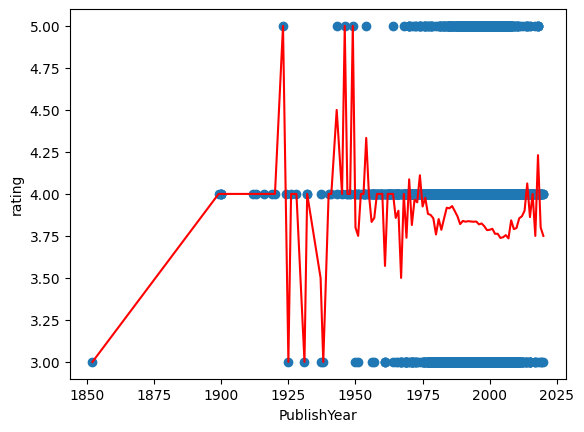

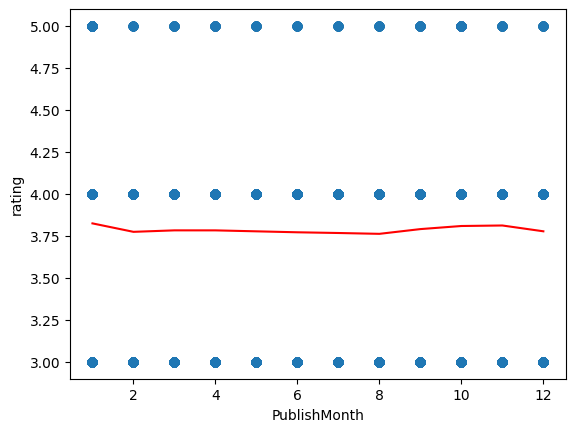

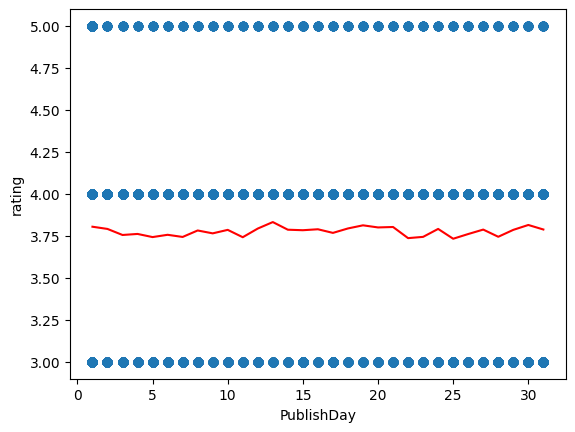

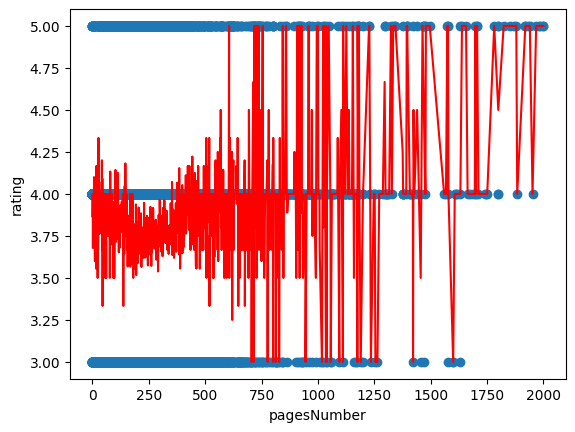

In [53]:
# Scatterplots for Publish year, month, and day vs. Rating
for feature in ['PublishYear', 'PublishMonth', 'PublishDay', 'pagesNumber']: 
    scatter_vs_rating(train_cpy, feature)
    
    # Look at the average rating for each value
    values, counts = np.unique(sorted(train_cpy[feature]), return_counts=True)
    avg = [sum(train_cpy.loc[train_cpy[feature] == values[i]][CLASS_LABEL]) / counts[i] for i in range(len(values))]
    plt.plot(values, avg, color = 'red')

    plt.show()

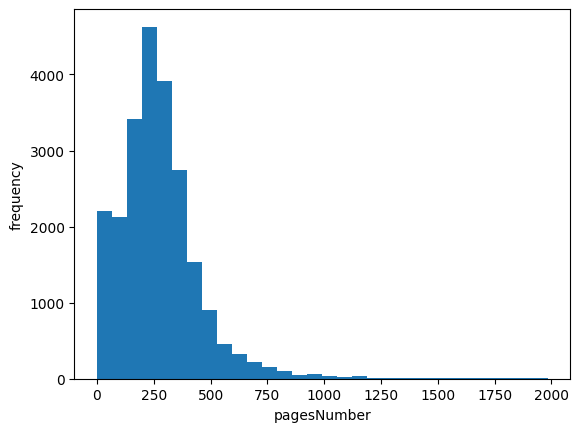

In [17]:
# Histogram for pages number < 2000
hist_plot(original_train_df.loc[original_train_df['pagesNumber'] < 2000], 'pagesNumber')

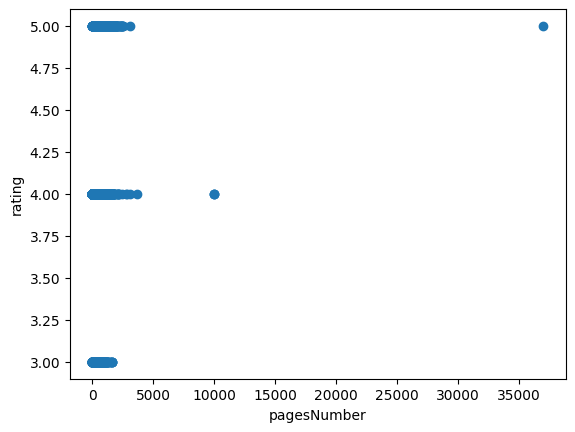

In [18]:
scatter_vs_rating(original_train_df, 'pagesNumber')
plt.show()

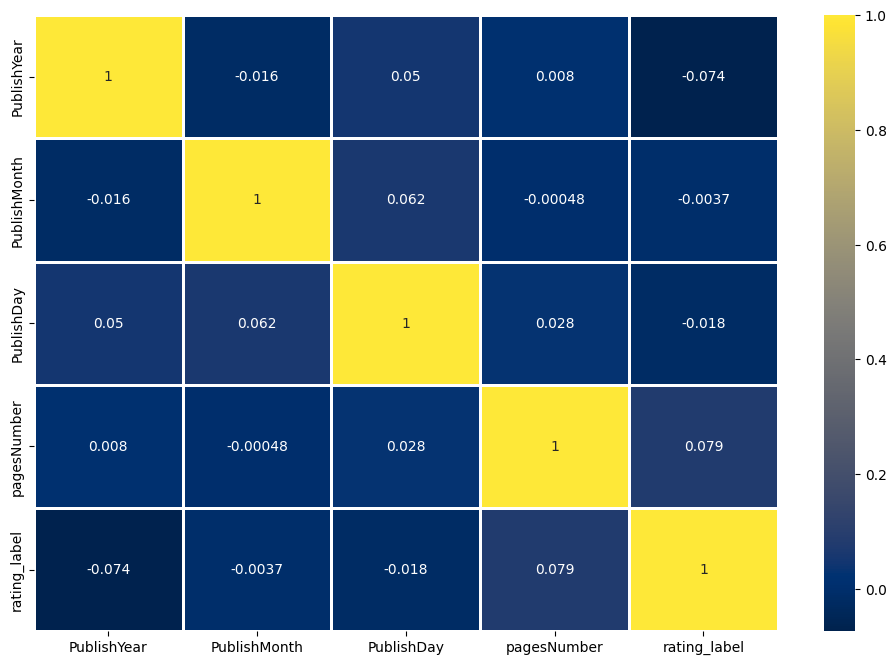

In [19]:
# Look at the correlation matrix of the numerical attributes
cor_matrix = original_train_df[NUMERICAL_FEATURES + [CLASS_LABEL]].corr()
round(cor_matrix, 2)
plt.figure(figsize=(12, 8))
sns.heatmap(cor_matrix, cmap='cividis', annot=True, linewidths=2)
plt.show()

In [20]:
# Order: ['PublishYear', 'PublishMonth', 'PublishDay', 'pagesNumber']
mutual_info_classif(train_df[NUMERICAL_FEATURES], train_df[CLASS_LABEL], discrete_features=[True, True, True, False])

array([0.00977533, 0.00115237, 0.00227827, 0.00706077])

In [21]:
for feature in NUMERICAL_FEATURES:
    print(f"AMI for {feature} =", adjusted_mutual_info_score(train_df[feature], train_df[CLASS_LABEL]))

AMI for PublishYear = 0.003001362164388505
AMI for PublishMonth = 0.00042120564481925796
AMI for PublishDay = 0.0005764790138975723
AMI for pagesNumber = 0.006588130691072023


In [22]:
# MI: top 2 = PublishYear, pagesNumber
# Correlation matrix: top 2 = PublishYear, pagesNumber
# Discard PublishMonth, PublishDay
#train_df = train_df.drop(['PublishMonth', 'PublishDay'], axis=1)

In [23]:
# Try discretizing it
from sklearn.preprocessing import KBinsDiscretizer

def discretize(df, feature, discretizer=None, strategy='kmeans', n_bins=5):
    if discretizer is None:
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        discretizer.fit(df[[feature]])
        
    transformed_df = df.copy()
    transformed_df[feature] = discretizer.transform(df[[feature]])
    
    return transformed_df, discretizer

In [24]:
DISCRETIZATION_STRATEGIES = ['kmeans', 'quantile', 'uniform']

def tune_discretization(X, y, feature, lower, upper):
    """
    Returns the combination of n (number of bins) and discretisation strategy 
    that gives the highest normalised mutual information between `X` and `y`.
    """
    
    max_ami = 0
    best_n = 0
    best_strategy = None
    
    for n in range(lower, upper+1):
        for strategy in DISCRETIZATION_STRATEGIES:
            transformed_X, _ = discretize(X, feature, strategy=strategy, n_bins=n)
            ami = adjusted_mutual_info_score(transformed_X[feature], y)
            if ami > max_ami:
                max_ami = ami
                best_n = n
                best_strategy = strategy
    
    return max_ami, best_n, best_strategy

In [25]:
nbins_upper = {'PublishYear': train_df['PublishYear'].nunique(), 'PublishMonth': 12, 'PublishDay': 31, 'pagesNumber': 30}

for feature in NUMERICAL_FEATURES:
    max_ami, best_n, best_strategy = tune_discretization(train_df, train_df[CLASS_LABEL], feature, 2, nbins_upper[feature])
    print("Feature:", feature)
    print("The number of bins that gives the highest AMI with rating_label is", best_n)
    print("The highest AMI is:", max_ami)
    print("The best strategy is:", best_strategy)
    print("\n")

# All AMI increased slightly after discretization

Feature: PublishYear
The number of bins that gives the highest AMI with rating_label is 15
The highest AMI is: 0.0058383814210868365
The best strategy is: uniform


Feature: PublishMonth
The number of bins that gives the highest AMI with rating_label is 6
The highest AMI is: 0.0005063750498256905
The best strategy is: quantile


Feature: PublishDay
The number of bins that gives the highest AMI with rating_label is 11
The highest AMI is: 0.0008658870757947885
The best strategy is: quantile


Feature: pagesNumber
The number of bins that gives the highest AMI with rating_label is 7
The highest AMI is: 0.012755377166113543
The best strategy is: kmeans




In [26]:
train_df, DISCRETIZER_PY = discretize(train_df, 'PublishYear', strategy='uniform', n_bins=15)
np.unique(train_df['PublishYear'], return_counts=True)

(array([ 0.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.]),
 array([    1,     5,     4,     6,     8,    19,    59,   233,  1080,
         5058, 16219,   371]))

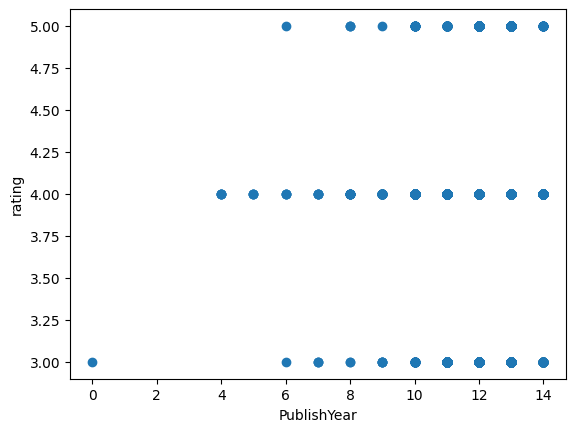

In [27]:
scatter_vs_rating(train_df, 'PublishYear')

In [28]:
train_df, DISCRETIZER_PM = discretize(train_df, 'PublishMonth', strategy='quantile', n_bins=6)
np.unique(train_df['PublishMonth'], return_counts=True)

(array([0., 1., 2., 3., 4., 5.]), array([2481, 3548, 4134, 5132, 2287, 5481]))

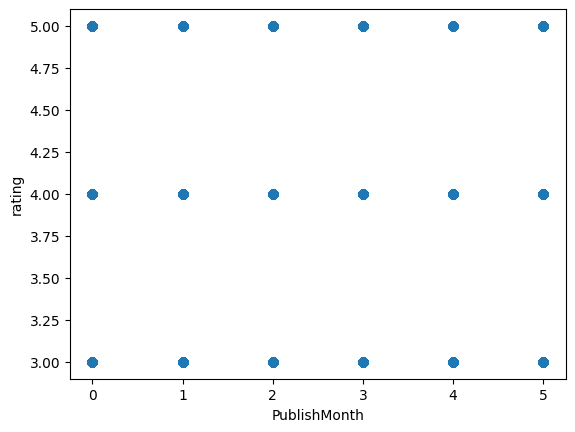

In [29]:
scatter_vs_rating(train_df, 'PublishMonth')

In [30]:
train_df, DISCRETIZER_PD = discretize(train_df, 'PublishDay', strategy='quantile', n_bins=11)
np.unique(train_df['PublishDay'], return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6.]),
 array([10149,  2283,  2049,  2030,  2306,  1741,  2505]))

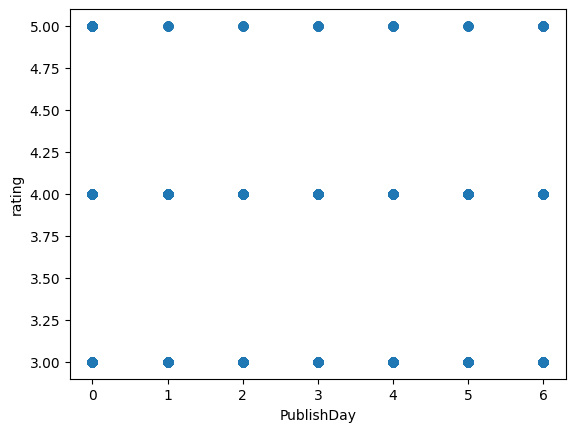

In [31]:
scatter_vs_rating(train_df, 'PublishDay')

In [32]:
train_df, DISCRETIZER_PN = discretize(train_df, 'pagesNumber', strategy='kmeans', n_bins=7)
np.unique(train_df['pagesNumber'], return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6.]),
 array([ 7578, 10024,  4422,   917,   118,     3,     1]))

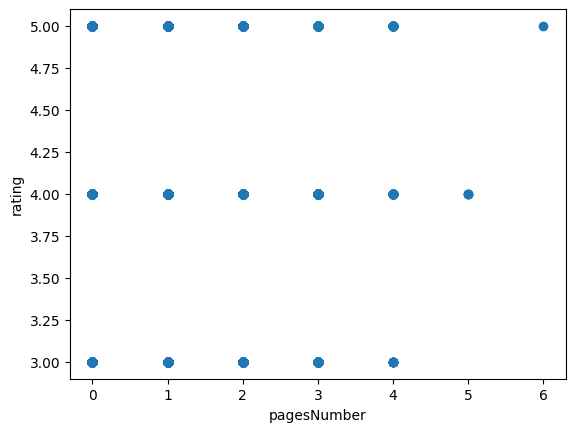

In [33]:
scatter_vs_rating(train_df, 'pagesNumber')

## Text Pre-processing

In [34]:
# We use a different delimiter for the name and description bigrams, to prevent duplicate column namaes
train_df_name, VECTORIZER_NAME = preprocess_text_feature(train_df, 'Name', ngram=2, delimiter='_', max_features=300)  # can try ngram=1
train_df_desc, VECTORIZER_DESC = preprocess_text_feature(train_df, 'Description', ngram=2, max_features=300)
# print(sorted(vectorizer_name.vocabulary_))
# print(sorted(vectorizer_desc.vocabulary_))

In [35]:
# Bind them together
train_df = pd.concat([train_df.reset_index(drop=True), train_df_name, train_df_desc], axis=1)
train_df = train_df.drop(TEXT_FEATURES, axis=1)  # drop the original columns

## Convert rating_label to categorical class label

In [36]:
# Finally, convert rating_label to categorical class label
train_df[CLASS_LABEL] = train_df[CLASS_LABEL].astype('category')
# move rating_label to the last column
labels = train_df[CLASS_LABEL]
train_df = pd.concat([train_df.drop([CLASS_LABEL], axis=1), labels], axis=1) 

In [37]:
DTYPE = train_df.dtypes.apply(lambda x: x.name).to_dict()  # needed for reading the CSV later
DTYPE['Authors'] = 'string'
DTYPE['Publisher'] = 'string'

In [38]:
# Save the general transformed df
train_df.to_csv(DATASET_DIR + "/train_df_300.csv", index=False)

In [39]:
print(train_df)

                      Authors  PublishYear  PublishMonth  PublishDay  \
0              jean r feldman         13.0           3.0         0.0   
1      gertrud mueller nelson         12.0           5.0         0.0   
2        constance w mcgeorge         13.0           1.0         6.0   
3          carolyn niethammer         13.0           4.0         0.0   
4               richard mason         13.0           3.0         1.0   
...                       ...          ...           ...         ...   
23058           henry rollins         12.0           3.0         0.0   
23059           david a adler         13.0           3.0         0.0   
23060    bronis aw malinowski         12.0           1.0         3.0   
23061             a e housman         13.0           2.0         4.0   
23062           scott wallens         13.0           3.0         2.0   

                           Publisher  pagesNumber  gay_lesbian  secret_life  \
0                 teaching resources          0.0       

## Preprocessing: Altogether

In [40]:
def preprocess_test_df(df):
    df = df.copy()
    
    # preprocess string features
    for feature in CATEGORICAL_FEATURES:
        df[feature] = df[feature].fillna(MISSING_CAT_VAL)  # imputation
        df[feature] = df[feature].apply(lambda x: preprocess(str(x), stop_words_removal=False, lemmatize=False, min_word_len=0))
    
    # preprocess pagesNumber and PublishYear
    df = discretize(df, 'PublishDay', discretizer=DISCRETIZER_PD)[0]
    df = discretize(df, 'PublishMonth', discretizer=DISCRETIZER_PM)[0]
    df = discretize(df, 'PublishYear', discretizer=DISCRETIZER_PY)[0]
    df = discretize(df, 'pagesNumber', discretizer=DISCRETIZER_PN)[0]
    
    # preprocess text features
    df_name = preprocess_text_feature(df, 'Name', vectorizer=VECTORIZER_NAME, delimiter='_', max_features=300)[0]
    df_desc = preprocess_text_feature(df, 'Description', vectorizer=VECTORIZER_DESC, max_features=300)[0]
    
    # discard the obsolete original features and unwanted features
    df = pd.concat([df.reset_index(drop=True), df_name, df_desc], axis=1)
    df = df.drop(['Name', 'Description', 'Language'], axis=1)
        
    return df

In [41]:
test_df = preprocess_test_df(original_test_df)
test_df.to_csv(DATASET_DIR + "/test_df_300.csv", index=False)
test_df

,Authors,PublishYear,PublishMonth,PublishDay,Publisher,pagesNumber,gay_lesbian,secret_life,travel_guide,seventeenth_century,...,want know,recent year,love affair,north america,paperback edition,book cover,br strong,family life,civil right,everything need
0,richard rohr,12.0,0.0,0.0,orbis books,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,robert j blake,12.0,1.0,4.0,puffin,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,martha r taylor,13.0,0.0,0.0,benjamin cummings,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,jo beverley,13.0,4.0,1.0,signet,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,michele kort,13.0,2.0,1.0,thomas dunne books,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.257535,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5761,jamie martinez wood,13.0,4.0,0.0,ten speed press,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5762,myra nour,13.0,4.0,2.0,ellora s cave,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5763,jos silva,13.0,5.0,3.0,editorial diana,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5764,erwin panofsky,10.0,3.0,4.0,westview press,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Now, we keep four versions of the transformed datasets
# a) Original
# b) Using one-hot encoding, with the full set of 'Authors' and 'Publisher' features
# c) Using one-hot encoding, with the chi2-selected set of 'Authors' and 'Publisher' features
# d) Using ordinal encoding
# Each model can choose their own version of dataset
train_df_ohe_full = ohe_transform(train_df, has_labels=True)
train_df_ohe_selected = train_df_ohe_full.drop(insig_cat_features_ohe, axis=1)  # drop the 'insignificant' OHE features
train_df_oe = ord_enc_transform(train_df)

train_df_ohe_full.to_csv(DATASET_DIR + "/train_df_ohe_full.csv", index=False)
train_df_ohe_selected.to_csv(DATASET_DIR + "/train_df_ohe_selected.csv", index=False)
train_df_oe.to_csv(DATASET_DIR + "/train_df_oe.csv", index=False)

In [43]:
test_df_ohe_full = ohe_transform(test_df)
test_df_ohe_selected = test_df_ohe_full.drop(insig_cat_features_ohe, axis=1)  # drop the 'insignificant' OHE features
test_df_oe = ord_enc_transform(test_df)

test_df_ohe_full.to_csv(DATASET_DIR + "/test_df_ohe_full.csv", index=False)
test_df_ohe_selected.to_csv(DATASET_DIR + "/test_df_ohe_selected.csv", index=False)
test_df_oe.to_csv(DATASET_DIR + "/test_df_oe.csv", index=False)

# 3. Final predictions on the test set

In [44]:
X_test_ohe = ohe_transform(test_df)
X_test_oe = ord_enc_transform(test_df)

In [45]:
model_sets = {snb: X_test_oe, RBF_svm: X_test_ohe, logr: X_test_ohe, hgb: X_test_oe}
y_test_preds = []
for model in model_sets:
    y_test_pred = model.predict(model_sets[model])
    y_test_preds.append(y_test_pred)


NameError: name 'snb' is not defined

In [ ]:
y_test_preds